## Reinforcement Learning: Policy Gradients


### Overview  <a name='objectives' />

This notebook introduces you Policy Gradients.

The topics that will be covered are:

* <a href=#cartpole>The CartPole Environment</a>
* <a href=#polgrad>Policy-gradients with a Neural Network (REINFORCE)</a>


### Programming Tasks
For the graded programming tasks you will need to replace the following comment and exception with your own code:

`# YOUR CODE HERE
raise NotImplementedError()`

Programming tasks are followed by a cell with tests (using the assert function from python). You can use these cells while developing your implementation and for validating your implementation. Note that there are also hidden test blocks which are not visible to you but these will also be used for grading your solutions.

-   [Task 1](#task1) (3 points)
-   [Task 2](#task2) (3 points)
-   [Task 3](#task3) (4 points)

### Points
Total points = 10

### Deadline
07.12.2020 23:59

### Miscellaneous

Refer to the [RL day 4 slides](https://iis.uibk.ac.at/uibk/auddy/rl-2020w/rl_day4.pdf) and the [notes](https://iis.uibk.ac.at/uibk/auddy/rl-2020w/rl-notes.pdf)

In [1]:
# Always execute this cell

# Libraries will not be installed if running on ifi-europa.uibk.ac.at

# Make sure that the required libraries are installed on your local system
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import os
running_local = True if os.getenv('JUPYTERHUB_USER') is None else False
    
if running_local:
    import sys
    !{sys.executable} -m pip install -r requirements_04_rl_pol_grad.txt

You should consider upgrading via the '/Users/tennismichel/Coding/Python/venv-advml/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import itertools
from itertools import count
import matplotlib.pyplot as plt
from tqdm import trange
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Set a seed for reproducing results
random_seed = 1234
np.random.seed(random_seed)
torch.manual_seed(random_seed)


<a href=#objectives> [go to top] </a>

### The CartPole Enviornment <a name='cartpole' />

In this assignment, we will use the `CartPole-v1` environment from openAI `gym`. Please check the details about the environment [here](https://gym.openai.com/envs/CartPole-v1/) or check the [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) of this environment for more details. A snapshot of the environment (when rendered) is shown below. 
<img src="cartpole.jpg" alt="see cartpole.jpg" width="400"/>

In this environment, there are 2 possible actions which the agent can take: applying a force of +1 or -1 to the cart. The state ($s \in \mathbb{R}^4$) of the environment is continuous and is denoted by 4 real numbers, as shown below:
```
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
```
The objective here is to choose actions based on the current state, such that the pole remains upright for as long as possible, thereby leading to greater returns.


To initialize the `CartPole-v1` environment, execute the cell below.

In [3]:
# Define the environment
env = gym.make('CartPole-v1')

# Set the seed for gym
env.seed(random_seed)


[1234]

In [4]:
# What is the type and size of the action space
print("Action space: {}".format(env.action_space))  # 2 discrete actions, 

# What does an action look like
sample_action = env.action_space.sample()  # Action can be one of these: 0, 1
print("Sample action: {}".format(sample_action))  # Execute multiple times to see different actions
print("Type of action: {}".format(type(sample_action)))

# What is the type and size of the observation (state) space
print("Observationtate space: {}".format(env.observation_space))  # continuous states

# Which state does the agent start in?
initial_state = env.reset()
print("Initial state: {}".format(initial_state))  

# What is an observation
sample_observation = env.observation_space.sample()
print("Sample observation: {}".format(sample_observation))
print("Type of observation: {}".format(type(sample_observation)))

Action space: Discrete(2)
Sample action: 1
Type of action: <class 'int'>
Observationtate space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Initial state: [-0.01315549 -0.04012824  0.04801855 -0.0044493 ]
Sample observation: [-3.6932671e+00 -1.7619946e+38  1.6151948e-01 -1.9803185e+38]
Type of observation: <class 'numpy.ndarray'>


<a href=#objectives> [go to top] </a>

### Policy-gradients with a Neural Network (REINFORCE) <a name='polgrad' />
You will now implement the REINFORCE algorithm ([RL Day 4 Slides, pg. 18](https://iis.uibk.ac.at/uibk/auddy/rl-2020w/rl_day4.pdf)), in which a policy function $\pi(a \vert s, \theta)$ is learned directly from the agent's interaction with the environment. You will be using a simple fully connected neural network as a function approximator for the policy function.

### Task 1<a name='task1' />

Implement a neural network that can act as a function approximator for the policy function for the `CartPole-v1` environment. The overall structure of this neural network is provided in the image below. There will be four inputs corresponding to the 4 dimensions of the state. Since you are dealing with an environment with discrete actions, this network will have 2 outputs, which are probabilities of the two actions. These probabilities are obtained by passing the output (numerical preferences of the 2 actions) of the network through a `Softmax` layer.

The image below only shows a conceptual diagram of the network. In practice there can be multiple hidden layers, and many units in each hidden layer.
<img src="policy_network.svg" alt="see policy_network.svg" width="640"/>

For this assignment, you will be using a network with 2 (fully-connected) hidden layers called `affine1` (containing 256 units) and `affine2` (containing 256 units), and an output layer called `affine3` (containing 2 units corresponding to the 2 actions - these are the numerical preferences as indicated in the figure above). All the layers of the network are defined for you in the `__init__` function. Your task is to complete the `forward` function of the network which takes the state as input and produces the action probabilities as output. Follow the comments that are provided. Other helper functions are already implemented for you.

**Note on Dropout**: You will also be utilizing Dropout, which is a powerful regularization technique (theoretical discussion about Dropout can be found in [the deep learning book, (chapter 7.12)](https://www.deeplearningbook.org/contents/regularization.html), PyTorch's implementation related documentation can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). Refer to these resources if you are interested, but for the purpose of this assignment, you don't require to know the details of how Dropout works.


In [5]:
####

In [6]:
# Test cell

test_policy = NeuralNetworkPolicy()
test_policy.eval()

with torch.no_grad():
    sample_observation = env.observation_space.sample()
    test_output = test_policy(torch.from_numpy(sample_observation).float().unsqueeze(0))
    assert isinstance(test_output, torch.Tensor) and test_output.shape==(1,2)
    for action_prob in test_output.detach().cpu().numpy().flatten():
        assert 0.0<=action_prob<=1.0
        
    # Sample a few actions
    for i in range(100):
        sample_observation = env.observation_space.sample()
        action = test_policy.select_action(sample_observation)
        assert action==0 or action==1
        
del test_policy

<a href=#objectives> [go to top] </a>

### Task 2<a name='task2' />

Your next task is to implement a function that computes the returns for each step of an episode from the list of rewards observed during an episode. Remember that if the rewards observed in a hypothetical 3-step episode are denoted by $[r_1, r_2, r_3]$, then the returns should be $\left[ \left(r_1 + \gamma r_2 + \gamma^2 r_3 \right), \left(r_2 + \gamma r_3 \right), \left(r_3\right) \right]$.

In [7]:
def compute_returns(rewards, gamma):
    """
    Function for computing returns from the list of rewards observed during an episode.
    
    Hint: Take special care of the fact that in the algorithm, the list of rewards are for 
    steps 1,2,...,T. Since Python follows a zero-based indexing system, the kth reward is 
    accessed by: rewards[k-1].
    
    Args:
        rewards (list): Rewards observed in an episode [r1, r1, ..., rT] for T steps.
    Returns:
        (list): List of returns.
    """
    returns = list()
    len_rewards = len(rewards)
    for i, reward in enumerate(rewards):
        return_i = 0
        k = 0 # k is exponent of gamma - j iterates through relevant rewards
        for j in range(i, len_rewards):
            return_i += gamma**k * rewards[j]
            k += 1
        returns.append(return_i) 
    return returns

In [8]:
# Test cell (includes hidden tests)

rewards = list(np.arange(1,11))
returns = compute_returns(rewards, gamma=1)
assert np.allclose(returns, [55, 54, 52, 49, 45, 40, 34, 27, 19, 10])


<a href=#objectives> [go to top] </a>

### Task 3<a name='task3' />

You will now need to implement the REINFORCE algorithm. To make this a little easier, the actual logic of the algorithm is split into 2 parts. As shown below, the calculation of the returns and the weight update is taken care of by the `finish_episode` function. Remember that since we are using PyTorch, we do not need to compute the gradients manually. All that is needed is to define the forward function of the policy network (which you have already done) and to define what the loss should be. The `finish_episode` function is provided to you. For computing the returns, it utilizes the `compute_returns` function you wrote earlier. Your task is to implement the the function `reinforce` which implements the main body of the REINFORCE algorithm.

<img src="reinforce.png" alt="see reinforce.png" width="700"/>

In [9]:
def finish_episode(policy, optimizer, gamma):
    """
    Performs the parameter updates of the policy network after an episode is completed.
    
    Args:
        policy (NeuralNetworkPolicy): The policy neural network.
        optimizer (child of torch.optim.Optimizer): Optimizer algorithm for gradient ascent.
        gamma (float): Discount factor in the range [0.0,1.0].
    """
    
    policy_loss = []

    # Define a small float which is used to avoid divison by zero
    eps = np.finfo(np.float32).eps.item()

    # Go through the list of observed rewards and calculate the returns
    returns = compute_returns(policy.rewards, gamma)

    # Convert the list of returns into a torch tensor
    returns = torch.tensor(returns)

    # Here we normalize the returns by subtracting the mean and dividing
    # by the standard deviation. Normalization is a standard technique in
    # deep learning and it improves performance, as discussed in 
    # http://karpathy.github.io/2016/05/31/rl/
    returns = (returns - returns.mean()) / (returns.std() + eps)

    # Here, we deviate slightly from the standard REINFORCE algorithm
    # Think why we use `-log_prob * G` instead of `log_prob * G`
    for log_prob, G in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * G)

    # Reset the gradients of the parameters
    optimizer.zero_grad()

    # Compute the cumulative loss
    policy_loss = torch.cat(policy_loss).mean()

    # Backpropagate the loss through the network
    policy_loss.backward()

    # Perform a parameter update step
    optimizer.step()

    # Reset the saved rewards and log probabilities
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [10]:
def reinforce(policy, optimizer, gamma=0.9, log_interval=100, max_episodes=1000, save=False):
    """
    Implementation of the main body of the REINFORCE algorithm.
    
    Args:
        policy (NeuralNetworkPolicy): The policy neural network.
        optimizer (child of torch.optim.Optimizer): Optimizer algorithm for gradient ascent.
        gamma (float): Discount factor in the range [0.0,1.0]. Defaults to 0.9.
        log_interval (int): Prints the progress after this many episodes. Defaults to 100.
        max_episodes (int): Maximum number of episodes to train for. Defaults to 1000.
        save (bool): Whether to save the trained network. Defaults to False.
        
    Returns:
        ep_rewards (list): List of actual cumulative rewards in each episode. 
        running_rewards (numpy array): List of smoothed cumulative rewards in each episode. 
    """

    # To track the reward across consecutive episodes (smoothed)
    running_reward = 1.0

    # Lists to store the episodic and running rewards for plotting
    ep_rewards = list()
    running_rewards = list()

    # Start executing an episode
    for i_episode in count(1):

        # Steps you need to implement
        # 1. Reset the environment
        state = env.reset()
        t = 0
        
        # 2. Initialize `ep_reward` (the total reward for this episode)
        ep_reward = 0
        
        # 3. For each step of the episode
        while (True):
            # 3.1 Select an action using the policy network
            action = policy.select_action(state)
            # action = self.select_action(state)
            
            # 3.2 Perform the action and note the next state and reward and if the episode is done
            state, reward, done, info = env.step(action)
            
            # 3.3 Store the current reward in `policy.rewards`
            policy.rewards.append(reward)
            
            # 3.4 Increment the total reward in this episode
            ep_reward += reward
            
            # Steps in episode for output required
            t += 1
            
            # 3.5 Check if the episode is finished using the `done` variable and break if yes
            if (done):
                break

        # Update the running reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward

        # Store the rewards for plotting
        ep_rewards.append(ep_reward)
        running_rewards.append(running_reward)
        
        # Perform the parameter update according to REINFORCE
        finish_episode(policy, optimizer, gamma)

        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        # Stopping criteria
        if running_reward > env.spec.reward_threshold:
            print('Running reward is now {} and the last episode ran for {} steps!'.format(running_reward, t))
            break
        if i_episode >= max_episodes:
            print('Max episodes exceeded, quitting.')
            break
    # Save the trained policy network
    if save:
        policy.save()

    return ep_rewards, running_rewards

In [11]:
def train_nn_policy(max_episodes=1000, **hyperparam_dict):
    """
    Function for training the neural network policy parameters with specified hyperparameters.
    """
    
    # Fetch the hyperparameters
    gamma = hyperparam_dict['gamma']
    learning_rate = hyperparam_dict['learning_rate']

    state_size = env.observation_space.shape[0]

    # Create the policy function and set the training mode
    policy = NeuralNetworkPolicy()
    policy.train()

    # Define the optimizer and set the learning rate
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    # Execute the REINFORCE algorithm
    ep_rewards, running_rewards = reinforce(policy, optimizer, max_episodes=max_episodes)
    
    del optimizer
    del policy
    
    return ep_rewards, running_rewards

In [12]:
# Test cell: Here we will just test that all the functions execute without error

# Run the REINFORCE algorithm 
hyperparam_dict = {'name': 'neural_network', 'gamma':0.9, 'learning_rate':5e-3}
ep_rewards, running_rewards = train_nn_policy(max_episodes=1, **hyperparam_dict)
assert len(ep_rewards)==len(running_rewards)

Max episodes exceeded, quitting.


<a href=#objectives> [go to top] </a>

In [13]:
# Actual training takes place here

# This will take a while to run

# A list for storing the hyperparameters and the corresponding results
results_neural_network = list()

# Run the REINFORCE algorithm 
hyperparam_dict = {'name': 'neural_network', 'gamma':0.9, 'learning_rate':5e-3}
ep_rewards, running_rewards = train_nn_policy(**hyperparam_dict)

# Store the results
results_neural_network.append((hyperparam_dict, ep_rewards, running_rewards))

Episode 100	Last reward: 114.00	Average reward: 134.96
Episode 200	Last reward: 138.00	Average reward: 213.85
Episode 300	Last reward: 95.00	Average reward: 274.11
Episode 400	Last reward: 500.00	Average reward: 462.29
Episode 500	Last reward: 160.00	Average reward: 181.42
Episode 600	Last reward: 361.00	Average reward: 214.35
Running reward is now 475.15316483255515 and the last episode ran for 500 steps!


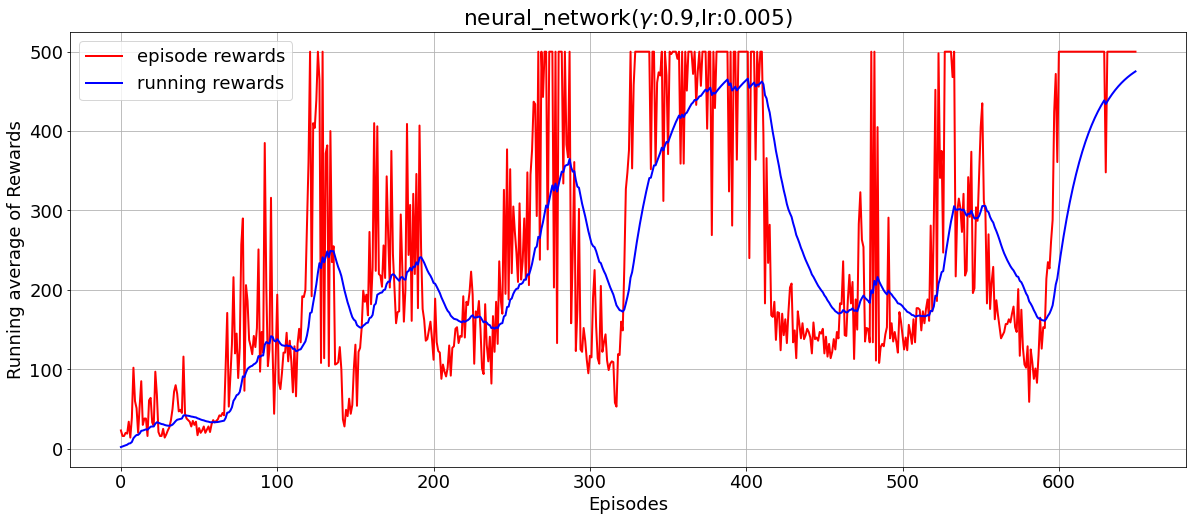

In [14]:
plt.rcParams.update({'font.size': 18})

# Plot the results
fig = plt.figure(1, figsize=(20,8))

for result in results_neural_network:
    hp = result[0]
    running_rewards = result[2]
    title_str = hp['name'] + '($\gamma$:' + str(hp['gamma']) + ',lr:' + str(hp['learning_rate']) + ')'
    plt.plot(range(len(ep_rewards)), ep_rewards, lw=2, color="red", label="episode rewards")
    plt.plot(range(len(running_rewards)), running_rewards, lw=2, color="blue", label="running rewards")
    plt.title(title_str)

plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Running average of Rewards')
plt.legend(ncol=1)
plt.show()

In [15]:
def train_nn_policy_save(max_episodes=1000, **hyperparam_dict):
    """
    Function for training the neural network policy parameters with specified hyperparameters.
    """
    
    # Fetch the hyperparameters
    gamma = hyperparam_dict['gamma']
    learning_rate = hyperparam_dict['learning_rate']

    state_size = env.observation_space.shape[0]

    # Create the policy function and set the training mode
    policy = NeuralNetworkPolicy()
    policy.train()

    # Define the optimizer and set the learning rate
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    # Execute the REINFORCE algorithm
    ep_rewards, running_rewards = reinforce(policy, optimizer, max_episodes=max_episodes, save=True)
    
    del optimizer
    del policy
    
    return ep_rewards, running_rewards

In [16]:
# Train and Save a network

# A list for storing the hyperparameters and the corresponding results
results_neural_network = list()

# Run the REINFORCE algorithm 
hyperparam_dict = {'name': 'neural_network', 'gamma':0.9, 'learning_rate':5e-3}
ep_rewards, running_rewards = train_nn_policy_save(**hyperparam_dict)

# Store the results
results_neural_network.append((hyperparam_dict, ep_rewards, running_rewards))

Episode 100	Last reward: 120.00	Average reward: 201.18
Episode 200	Last reward: 135.00	Average reward: 195.36
Episode 300	Last reward: 500.00	Average reward: 458.64
Episode 400	Last reward: 41.00	Average reward: 139.48
Episode 500	Last reward: 500.00	Average reward: 390.13
Running reward is now 475.175482136948 and the last episode ran for 500 steps!


In [20]:
from IPython import display
%matplotlib inline

# Visualization
# policy = NeuralNetworkPolicy.load(state_file='models/policy_network_solved.pt')
policy = NeuralNetworkPolicy.load(state_file='models/policy_network.pt')
        
# For each step of the episode
for episode in range(0,5):
    state = env.reset()
    t = 0

    # Initialize `ep_reward` (the total reward for this episode)
    ep_reward = 0
    while (True):
        # Render env
        # plt.imshow(env.render(mode='rgb_array'))
        # display.display(plt.gcf())
        # display.clear_output(wait=True)
        ### env.render(mode='rgb_array')

        # 3.1 Select an action using the policy network
        action = policy.select_action(state)
        # action = self.select_action(state)

        # 3.2 Perform the action and note the next state and reward and if the episode is done
        state, reward, done, info = env.step(action)

        # 3.3 Store the current reward in `policy.rewards`
        policy.rewards.append(reward)

        # 3.4 Increment the total reward in this episode
        ep_reward += reward

        # Steps in episode for output required
        t += 1

        # 3.5 Check if the episode is finished using the `done` variable and break if yes
        if (done):
            break
    print('Episode: ', episode)
    print('Time Steps: ', t)
    print('Reward: ', ep_reward)

Episode:  0
Time Steps:  500
Reward:  500.0
Episode:  1
Time Steps:  500
Reward:  500.0
Episode:  2
Time Steps:  500
Reward:  500.0
Episode:  3
Time Steps:  500
Reward:  500.0
Episode:  4
Time Steps:  500
Reward:  500.0
